In [11]:
import json
import os

import chromadb
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn.functional as F
from chromadb.utils import embedding_functions
from tqdm.notebook import tqdm
from transformers import AutoModel, AutoTokenizer

In [12]:
from openai import OpenAI
from chromadb import Documents, EmbeddingFunction, Embeddings

class Embedder(EmbeddingFunction):
    def __init__(self):
        self.client = OpenAI(base_url="http://localhost:5000/v1", api_key="lm-studio")
        self.model = "CompendiumLabs/bge-base-en-v1.5-gguf"

    def __call__(self, input:Documents) -> Embeddings:
        return [d.embedding for d in self.client.embeddings.create(input = input, model=self.model).data]


In [13]:
# https://docs.trychroma.com/guides
CHROMA_DATA_PATH = r"C:\Users\ihett\OneDrive\Gabrilyi\arxiv_project\chroma_data"
# EMBED_MODEL = "all-MiniLM-L6-v2"
# EMBED_MODEL = "all-mpnet-base-v2"
EMBED_MODEL = "bge-base-en"
COLLECTION_NAME = "arxiv_papers"
BATCH_SIZE = 1000

CHROMA_DATA_PATH = os.path.join(CHROMA_DATA_PATH, EMBED_MODEL)

In [14]:
cache_dir = 'cache'
if not os.path.exists(cache_dir):
    os.makedirs(cache_dir)

# parquet_path = '../data/arxiv_metadata_sample.parquet.gzip'
parquet_path = r"C:\Users\ihett\OneDrive\Gabrilyi\arxiv_project\arxiv_metadata_sample.parquet.gzip"
arxiv_df = pd.read_parquet(parquet_path)
arxiv_df = arxiv_df.sample(20000)

print(arxiv_df.shape)

(20000, 14)


In [15]:
def text_processing(sample):
    title = sample['title']
    abstract = sample['abstract']

    # remove special characters
    title = title.replace('\n', ' ').replace('\r', ' ').replace('\t', ' ')
    abstract = abstract.replace('\n', ' ').replace('\r', ' ').replace('\t', ' ')

    # remove multiple spaces
    title = ' '.join(title.split())
    abstract = ' '.join(abstract.split())

    return f"Title: {title} - Abstract: {abstract}"

In [16]:
arxiv_df['text'] = arxiv_df.apply(text_processing, axis=1)
arxiv_df.head(3)

,id,title,abstract,categories,update_date,title_words,abstract_words,mapped_categories,amount_categories,update_year,super_categories,amount_super_categories,super_categories_str,super_category,text
95433,2007.09504,Dynamical ${\frak{sl}}_2$ Bethe algebra and fu...,We consider the space $\text{Fun}_{\frak{sl}...,"[math-ph, math.AG, math.MP, math.QA]",2020-07-23,10,66,"[Mathematical Physics, Algebraic Geometry, Mat...",4,2020,"[Physics, Mathematics, Physics, Mathematics]",4,Mathematics Physics,Mathematics,Title: Dynamical ${\frak{sl}}_2$ Bethe algebra...
80619,cond-mat/0411145,Collective roughening of elastic lines with ha...,We investigate by exact optimization methods...,"[cond-mat.dis-nn, cond-mat.supr-con]",2009-11-10,13,61,"[Disordered Systems and Neural Networks, Super...",2,2009,[Materials Science and Condensed Matter Physic...,2,Materials Science and Condensed Matter Physics,Materials Science and Condensed Matter Physics,Title: Collective roughening of elastic lines ...
61739,1107.5852,Necessary and sufficient conditions in the pro...,We consider a problem of optimal investment ...,[q-fin.PM],2012-07-17,13,52,[Portfolio Management],1,2012,[Economics and Finance],1,Economics and Finance,Economics and Finance,Title: Necessary and sufficient conditions in ...


In [17]:
def create_metadatas(arxiv_df):
    metadatas = []
    for _, row in arxiv_df.iterrows():
        metadatas.append({
            "update_date": row['update_date'],
            "title_words": row['title_words'],
            "abstract_words": row['abstract_words'],
            "super_category": row['super_category'],
            "mapped_categories": ";".join(row['mapped_categories']),
        })

    return metadatas

In [18]:
def create_collection(client, collection_name, embedding_function):
    collection = client.create_collection(
        name=collection_name,
        embedding_function=embedding_function,
        metadata={"hnsw:space": "cosine"},
        get_or_create=True,
    )

    return collection

def delete_collection_data(client, collection, collection_name):
    print(f"Deleting data from collection {collection_name} with {collection.count()} documents")
    client.delete_collection(collection_name)

def get_random_samples_from_collection(collection, n_samples):
    collection_ids = collection.get()["ids"]
    random_ids = np.random.choice(collection_ids, n_samples, replace=False).tolist()
    documents = collection.get(ids=random_ids)
    return documents

def upsert_data(collection, arxiv_df, metadatas, batch_size):
    for i in tqdm(range(0, len(arxiv_df), batch_size)):
        collection.upsert(
            documents=arxiv_df['text'].iloc[i:i + batch_size].tolist(),
            ids=arxiv_df['id'].iloc[i:i + batch_size].tolist(),
            metadatas=metadatas[i:i + batch_size],
        )

In [19]:
# delete the collection if it exists
client = chromadb.PersistentClient(path=CHROMA_DATA_PATH)

# embedding_func = embedding_functions.SentenceTransformerEmbeddingFunction(
#     model_name=EMBED_MODEL,
#     device="cuda",
# )

embedder = Embedder()
collection = create_collection(client, COLLECTION_NAME, embedder)
#
# delete if you want to start fresh but then you need to create the collection again
delete_collection_data(client, collection, COLLECTION_NAME)
collection = create_collection(client, COLLECTION_NAME, embedder)

# create metadatas
metadatas = create_metadatas(arxiv_df)

# upsert data (insert or update if exists)
upsert_data(collection, arxiv_df, metadatas, BATCH_SIZE)

Deleting data from collection arxiv_papers with 5000 documents


  0%|          | 0/20 [00:00<?, ?it/s]

In [20]:
# Define query
words_per_line = 10
# define papers to show
top_n_papers = 3
query = "Deep Learning and veganism"
print("Query:\n", query, "\n")
query_results = collection.query(query_texts=[query], n_results=top_n_papers)
for _id, _doc, _dist, _meta in zip(query_results["ids"][0], query_results["documents"][0], query_results["distances"][0], query_results["metadatas"][0]):
    print(f"#####   ID: {_id}   #####")
    print(f"Distance: {_dist}")
    print(f"Metadata: {_meta}")
    _doc_lines = _doc.split()
    for i in range(0, len(_doc_lines), words_per_line):
        print(" ".join(_doc_lines[i:i + words_per_line]))
    print("\n")

Query:
 Deep Learning and veganism 

#####   ID: 2106.13731   #####
Distance: 0.27979135513305664
Metadata: {'abstract_words': 131, 'mapped_categories': 'Machine Learning', 'super_category': 'Artificial Intelligence', 'title_words': 6, 'update_date': '2021-08-10'}
Title: Ranger21: a synergistic deep learning optimizer - Abstract: As
optimizers are critical to the performances of neural networks, every
year a large number of papers innovating on the subject
are published. However, while most of these publications provide incremental
improvements to existing algorithms, they tend to be presented as
new optimizers rather than composable algorithms. Thus, many worthwhile improvements
are rarely seen out of their initial publication. Taking advantage
of this untapped potential, we introduce Ranger21, a new optimizer
which combines AdamW with eight components, carefully selected after reviewing
and testing ideas from the literature. We found that the
resulting optimizer provides significantl

In [21]:
response = collection.get(include=["metadatas", "documents", "embeddings"])
df = pd.DataFrame({
    "id": response["ids"],
    "document": response["documents"],
    "embedding": response["embeddings"],
    "super_category": [x["super_category"] for x in response["metadatas"]],
})
# all_categories = df["categories"].explode().unique()
all_categories = df["super_category"].unique()
cat_mapping = {cat: i for i, cat in enumerate(all_categories)}
df["cat_id"] = df["super_category"].apply(lambda x: cat_mapping[x])
# df.loc[:, all_categories] = df["super_category"].apply(lambda x: [1 if cat in x else 0 for cat in all_categories]).tolist()
df.head(3)

,id,document,embedding,super_category,cat_id
0,1001.0039,"Title: TGCat, The Chandra Transmission Grating...","[-0.01459228340536356, -0.024912899360060692, ...",Astrophysics and Cosmology,0
1,1001.019,Title: Kepler-7b: A Transiting Planet with Unu...,"[-0.06372591853141785, -0.011273687705397606, ...",Earth and Environmental Sciences,1
2,1001.0256,Title: Initial Characteristics of Kepler Long ...,"[-0.041602279990911484, -0.021404078230261803,...",Earth and Environmental Sciences,1


In [ ]:
from renumics import spotlight

spotlight.show(df)

# Simple Classification Head

In [ ]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset


class EmbeddingDataset(Dataset):
    def __init__(self, df, cat_ids):
        self.ids = df["id"].values
        self.embeddings = torch.tensor(df["embedding"].tolist(), dtype=torch.float32)
        self.categories = torch.tensor(df["cat_id"].values, dtype=torch.long)

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        return self.ids[idx], self.embeddings[idx], self.categories[idx]

class EmbeddingModel(torch.nn.Module):
    def __init__(self, n_emb_size, n_categories):
        super(EmbeddingModel, self).__init__()
        self.fc1 = torch.nn.Linear(n_emb_size, 512)
        self.fc2 = torch.nn.Linear(512, 256)
        self.fc3 = torch.nn.Linear(256, n_categories)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

# train val split
emb_dataset = EmbeddingDataset(df, cat_mapping)
train_size = int(0.8 * len(emb_dataset))
val_size = len(emb_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(emb_dataset, [train_size, val_size])

print(f"Train size: {len(train_dataset)}")
print(f"Val size: {len(val_dataset)}")

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EmbeddingModel(len(df["embedding"].values[0]), len(all_categories)).to(device)

Train size: 95602
Val size: 23901


In [ ]:
def train(model, train_loader, val_loader, epochs=10):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    criterion = torch.nn.CrossEntropyLoss()
    for epoch in range(epochs):
        model.train()
        for _, emb, cat in train_loader:
            emb, cat = emb.to(device), cat.to(device)
            optimizer.zero_grad()
            output = model(emb)
            loss = criterion(output, cat)
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            for _, emb, cat in val_loader:
                emb, cat = emb.to(device), cat.to(device)
                output = model(emb)
                _, predicted = torch.max(output.data, 1)
                total += cat.size(0)
                correct += (predicted == cat).sum().item()

            print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}, Accuracy: {100 * correct / total}")

train(model, train_loader, val_loader, epochs=10)

Epoch 1/10, Loss: 0.7556178569793701, Accuracy: 75.83364712773525
Epoch 2/10, Loss: 0.42003190517425537, Accuracy: 76.75829463202376
Epoch 3/10, Loss: 0.38508155941963196, Accuracy: 77.54068867411405
Epoch 4/10, Loss: 0.8198814988136292, Accuracy: 77.73314924061755
Epoch 5/10, Loss: 0.780788004398346, Accuracy: 77.75825279277018
Epoch 6/10, Loss: 0.8643059134483337, Accuracy: 78.2268524329526
Epoch 7/10, Loss: 0.5760236978530884, Accuracy: 78.4611522530438
Epoch 8/10, Loss: 0.41133925318717957, Accuracy: 78.4611522530438
Epoch 9/10, Loss: 0.18678654730319977, Accuracy: 78.75402702815782
Epoch 10/10, Loss: 0.4386148750782013, Accuracy: 78.83352160997448


# cluster

In [23]:
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

num_classes = len(cat_mapping)
print(f"Number of classes: {num_classes}")
# arxiv_df['class'] = arxiv_df['super_category'].apply(lambda x: cat_mapping[x])
df['class'] = df['super_category'].apply(lambda x: cat_mapping[x])
p_per_class = 1
# only use p_per_class percent of each class
sampled_df = df.groupby('class').apply(lambda x: x.sample(frac=p_per_class, random_state=42)).reset_index(drop=True)
print(f"Sampled data shape: {sampled_df.shape}")

Number of classes: 12
Sampled data shape: (20000, 6)


C:\Users\ihett\AppData\Local\Temp\ipykernel_8236\1386924412.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = df.groupby('class').apply(lambda x: x.sample(frac=p_per_class, random_state=42)).reset_index(drop=True)


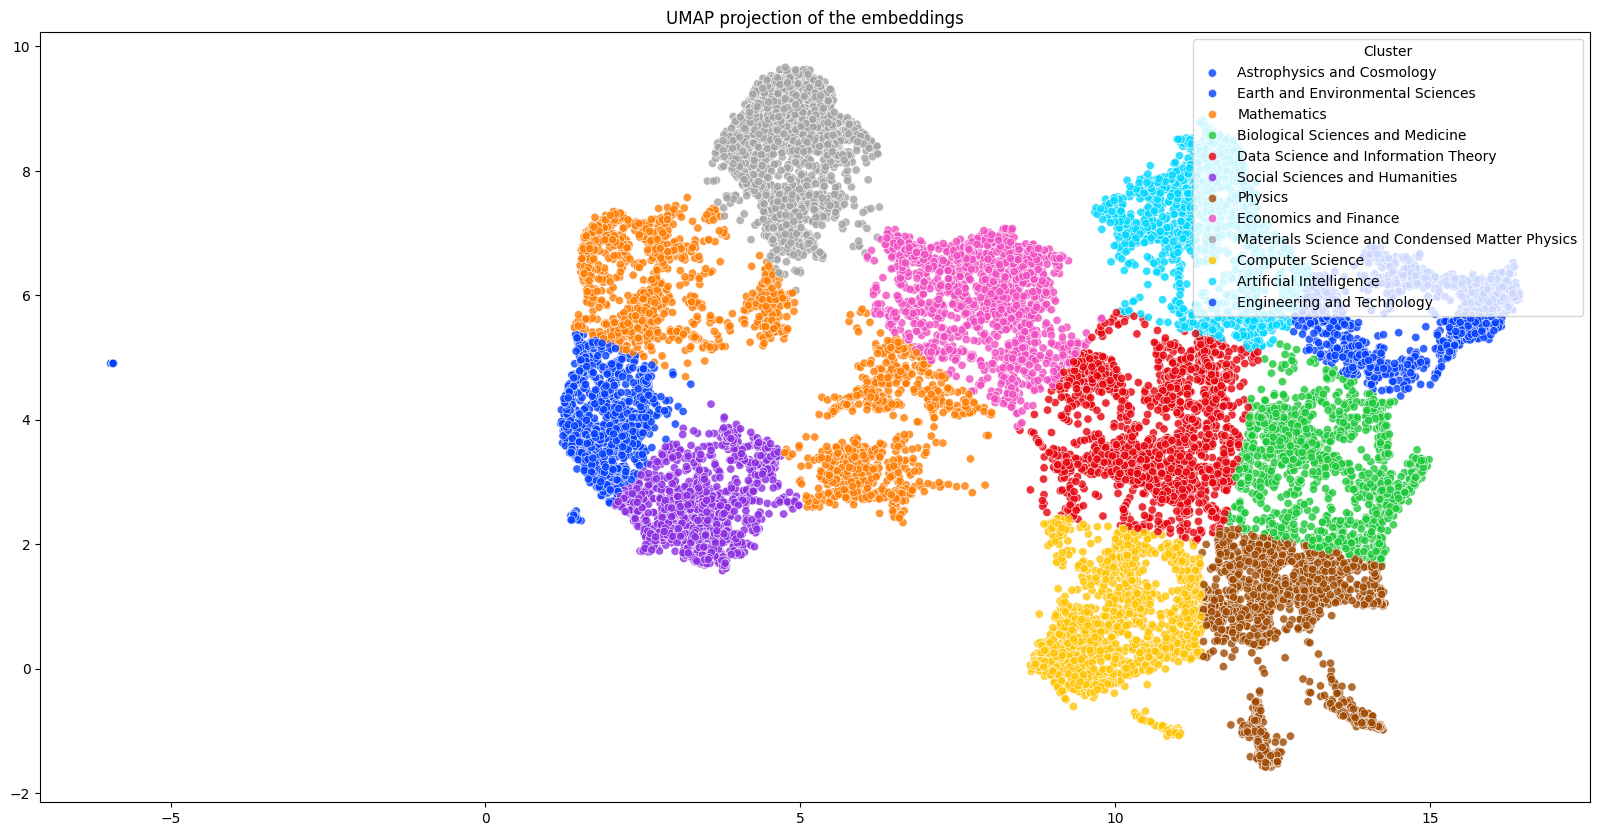

In [24]:
import umap
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Normalizing the data
embedding_data = np.array(sampled_df["embedding"].tolist())
# scaler = StandardScaler()
# embedding_data_scaled = scaler.fit_transform(embedding_data)

# UMAP
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, metric='cosine')
umap_embeddings = umap_model.fit_transform(embedding_data)

# K-Means Clustering
kmeans = KMeans(n_clusters=num_classes, random_state=42)
kmeans_labels = kmeans.fit_predict(umap_embeddings)

# visualize
plt.figure(figsize=(20, 10))
sns.scatterplot(
    x=umap_embeddings[:, 0],
    y=umap_embeddings[:, 1],
    hue=kmeans_labels,
    palette=sns.color_palette("bright", num_classes),
    legend="full",
    alpha=0.8,
)

plt.title("UMAP projection of the embeddings")
# Add cluster names from df["super_category"]
plt.legend(title="Cluster", loc="upper right", labels=all_categories)
plt.show()

In [25]:
import plotly.express as px

# Create a dataframe for plotly
plot_df = pd.DataFrame(umap_embeddings, columns=['UMAP 1', 'UMAP 2'])
plot_df['Cluster'] = kmeans_labels
plot_df['Class'] = df['cat_id']

# Define markers for actual classes
markers = ['circle', 'square', 'triangle-up', 'diamond', 'triangle-down', 'triangle-left', 'triangle-right', 'pentagon', 'star', 'hexagon']

# Create a new column for marker shapes
plot_df['Marker'] = plot_df['Class'].apply(lambda x: markers[x % len(markers)])

# Plot using plotly
fig = px.scatter(plot_df, x='UMAP 1', y='UMAP 2', color='Cluster', symbol='Marker',
                 title="UMAP embeddings colored by KMeans labels and shaped by actual classes",
                 symbol_map={str(i): marker for i, marker in enumerate(markers)}, width=1800, height=800)

fig.update_traces(marker=dict(size=5))  # Adjust the marker size
fig.show()

In [28]:
# calculate accuracy
def calculate_accuracy(df, kmeans_labels, cat_mapping):
    df["kmeans_labels"] = kmeans_labels
    correct = 0
    total = 0
    for cat, kmeans_label in zip(df["cat_id"], df["kmeans_labels"]):
        if cat == kmeans_label:
            correct += 1
        total += 1

    return correct / total

accuracy = calculate_accuracy(sampled_df, kmeans_labels, cat_mapping)
print(f"Accuracy: {accuracy}")

Accuracy: 0.08535


In [27]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score

embeddings_to_eval = sampled_df["embedding"].tolist().copy()
# Perform KMeans clustering
kmeans = KMeans(n_clusters=num_classes, random_state=42)
cluster_labels = kmeans.fit_predict(embeddings_to_eval)
# Adjusted Rand Index (ARI)
ari = adjusted_rand_score(sampled_df["super_category"], cluster_labels)
print(f"Adjusted Rand Index (ARI): {ari:.4f}")

# Normalized Mutual Information (NMI)
nmi = normalized_mutual_info_score(sampled_df["super_category"], cluster_labels)
print(f"Normalized Mutual Information (NMI): {nmi:.4f}")

# Silhouette Score
silhouette_avg = silhouette_score(embeddings_to_eval, sampled_df["super_category"])
print(f"Silhouette Score: {silhouette_avg:.4f}")

Adjusted Rand Index (ARI): 0.3793
Normalized Mutual Information (NMI): 0.5072
Silhouette Score: 0.0310
